<a href="https://colab.research.google.com/github/jiwooya1000/KOR-Multimodal-Emotion-Recognition/blob/main/3-1.%20Text_Valence_Model_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 Valence 예측 모델 학습**

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install torchmetrics

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kobert 0.2.3 requires transformers>=4.8.1, but you have transformers 3.0.2 which is incompatible.
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-pldsf4ea
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-pldsf4ea
  Using cached transformers-4

In [ ]:
import torch
import time
import os
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import gluonnlp as nlp
import matplotlib.pyplot as plt
from tqdm import tqdm
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertTokenizer, BertModel
from kobert import get_pytorch_kobert_model
from sklearn.metrics import f1_score

In [ ]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

# Directory 변경
directory = "주분"
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **1. 데이터로더 준비**

In [ ]:
# KoBERT tokenizer 및 모델 불러오기

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
model, vocab = get_pytorch_kobert_model()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


using cached model. /content/gdrive/My Drive/주분/.cache/kobert_v1.zip
using cached model. /content/gdrive/MyDrive/주분/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
# Custom Dataset 불러오기

from dataloader import *

In [ ]:
# Custom Dataset 객체 생성(Train Set)

dataset_train = KEMDset(file='train_aft_aug_kobert.pickle', tokenizer=tokenizer, balance=False, shuffle=True)

100%|██████████| 10043/10043 [00:08<00:00, 1154.55it/s]


In [ ]:
# DataLoader 정의

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16,
                                               shuffle=False, drop_last=True)

In [ ]:
# Custom Dataset 객체 생성(Valid Set)

dataset_valid = KEMDset(file='valid_tokenized.pickle', tokenizer=tokenizer, balance=False, shuffle=True)

100%|██████████| 1018/1018 [00:00<00:00, 1282.40it/s]


In [ ]:
# DataLoader 정의

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16,
                                               shuffle=False, drop_last=True)

## **2. 모델**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 모델 정의해놓은 모듈 불러오기

from text_model import *
from EarlyStopping import *

In [ ]:
import importlib
import text_model
importlib.reload(text_model)
from text_model import *

In [ ]:
# 모델 객체 생성

model = TextRegressor(n_layers=5).to(device)

using cached model. /content/gdrive/MyDrive/주분/.cache/kobert_v1.zip
using cached model. /content/gdrive/MyDrive/주분/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


## **3. 학습**

In [ ]:
# 하이퍼 파라미터 설정

learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6) 

In [ ]:
# 모델 학습

epochs=30
train_losses = []
valid_losses = []

start_time = time.time()
es = EarlyStopping(patience=8, path='text_valence.pt')

for epoch in range(epochs):
    
    #########
    # Train #
    #########
    model.train()
    train_loss = 0
    
    for i, dict in enumerate(dataloader_train):
        input_ids = dict['input_ids'].to(device=device, dtype=torch.int32)
        token_type_ids = dict['token_type_ids'].to(device=device, dtype=torch.int32)
        attention_mask = dict['attention_mask'].to(device=device, dtype=torch.int32)
        targets = dict['valence'].to(device=device, dtype=torch.float32).unsqueeze(1)

        scores, features = model(input_ids, token_type_ids, attention_mask)
        
        # 가중치 쓰려면 (weight=loss_weight)
        loss_fn = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        loss = torch.sqrt(loss_fn(scores, targets))

        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
        
    ##############
    # Validation #
    ##############
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for i, dict in enumerate(dataloader_valid):
            input_ids = dict['input_ids'].to(device=device, dtype=torch.int32)
            token_type_ids = dict['token_type_ids'].to(device=device, dtype=torch.int32)
            attention_mask = dict['attention_mask'].to(device=device, dtype=torch.int32)
            targets = dict['valence'].to(device=device, dtype=torch.float32).unsqueeze(1)
  
            scores, features = model(input_ids, token_type_ids, attention_mask)
            _, preds = scores.max(dim=1)

            valid_loss += torch.sqrt(loss_fn(scores, targets))

    #######
    # Log #
    #######
    train_losses.append(train_loss.detach().cpu().numpy() / len(dataloader_train))
    valid_losses.append(valid_loss.detach().cpu().numpy() / len(dataloader_valid))

    elapsed_time = time.time() - start_time
        
    print(f"[{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}] Epoch {epoch+1:2d} \
    >>> Train RMSE Loss: {train_losses[-1]:6.4f} \
    >>> Valid RMSE Loss: {valid_losses[-1]:6.4f} ")
    
    es(valid_losses[-1], model)

    if es.early_stop:
        print('Early Stopping Activated!')
        break

# torch.save(model.state_dict(), 'text_valence.pt')

[00:00:44] Epoch  1     >>> Train RMSE Loss: 0.6819     >>> Valid RMSE Loss: 0.4670 
[00:01:30] Epoch  2     >>> Train RMSE Loss: 0.4585     >>> Valid RMSE Loss: 0.4327 
[00:02:16] Epoch  3     >>> Train RMSE Loss: 0.4328     >>> Valid RMSE Loss: 0.4280 
[00:03:01] Epoch  4     >>> Train RMSE Loss: 0.4193     >>> Valid RMSE Loss: 0.4280 
[00:03:47] Epoch  5     >>> Train RMSE Loss: 0.4135     >>> Valid RMSE Loss: 0.4299 
EarlyStopping counter: 1 out of 8
[00:04:31] Epoch  6     >>> Train RMSE Loss: 0.4065     >>> Valid RMSE Loss: 0.4284 
EarlyStopping counter: 2 out of 8
[00:05:15] Epoch  7     >>> Train RMSE Loss: 0.4030     >>> Valid RMSE Loss: 0.4264 
[00:06:01] Epoch  8     >>> Train RMSE Loss: 0.4003     >>> Valid RMSE Loss: 0.4254 
[00:06:46] Epoch  9     >>> Train RMSE Loss: 0.4002     >>> Valid RMSE Loss: 0.4252 
[00:07:32] Epoch 10     >>> Train RMSE Loss: 0.3986     >>> Valid RMSE Loss: 0.4254 
EarlyStopping counter: 1 out of 8
[00:08:16] Epoch 11     >>> Train RMSE Loss: 0.3

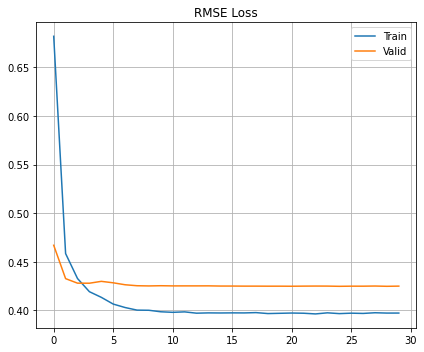

In [ ]:
# 시각화

plt.figure(figsize=(6,5))

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('RMSE Loss')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import csv

with open('[Text]n_layers=5.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(train_losses)
    writer.writerow(valid_losses)